In [1]:
pip install pandas numpy matplotlib seaborn scipy plotly missingno


Note: you may need to restart the kernel to use updated packages.


In [2]:
# === Step 1: Setup ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
sns.set(font_scale=1.1)

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 160)

print("Environment ready ✔")


Environment ready ✔


In [3]:
import os
os.getcwd()


'C:\\Users\\mihir'

In [4]:
import pandas as pd

df = pd.read_csv("sensor_maintenance_data.csv")
df.columns


Index(['Sensor_ID', 'Timestamp', 'Voltage (V)', 'Current (A)', 'Temperature (°C)', 'Power (W)', 'Humidity (%)', 'Vibration (m/s²)', 'Equipment_ID',
       'Operational Status', 'Fault Status', 'Failure Type', 'Last Maintenance Date', 'Maintenance Type', 'Failure History', 'Repair Time (hrs)',
       'Maintenance Costs (USD)', 'Ambient Temperature (°C)', 'Ambient Humidity (%)', 'External Factors', 'X', 'Y', 'Z', 'Equipment Relationship',
       'Equipment Criticality', 'Fault Detected', 'Predictive Maintenance Trigger'],
      dtype='object')

In [5]:
ahu_df = pd.read_csv("combined_SDAHU.csv")
ahu_df.columns


Index(['Datetime', 'CHWC_VLV', 'CHWC_VLV_DM', 'MA_TEMP', 'OA_CFM', 'OA_DMPR', 'OA_DMPR_DM', 'OA_TEMP', 'RA_CFM', 'RA_DMPR', 'RA_DMPR_DM', 'RA_TEMP', 'RF_CS',
       'RF_SPD', 'RF_SPD_DM', 'RF_WAT', 'SA_CFM', 'SA_SP', 'SA_SPSPT', 'SA_TEMP', 'SA_TEMPSPT', 'SF_CS', 'SF_SPD', 'SF_SPD_DM', 'SF_WAT', 'SYS_CTL',
       'ZONE_TEMP_1', 'ZONE_TEMP_2', 'ZONE_TEMP_3', 'ZONE_TEMP_4', 'ZONE_TEMP_5', 'system_type', 'source_file', 'scenario'],
      dtype='object')

In [6]:
# Corrected CSV loading with correct datetime columns

sens = pd.read_csv("sensor_maintenance_data.csv", parse_dates=["Timestamp"])
ahu  = pd.read_csv("combined_SDAHU.csv", parse_dates=["Datetime"])

print("Sensor Data:", sens.shape)
print("AHU Data:", ahu.shape)

sens.head()


Sensor Data: (500, 27)
AHU Data: (10818901, 34)


,Sensor_ID,Timestamp,Voltage (V),Current (A),Temperature (°C),Power (W),Humidity (%),Vibration (m/s²),Equipment_ID,Operational Status,Fault Status,Failure Type,Last Maintenance Date,Maintenance Type,Failure History,Repair Time (hrs),Maintenance Costs (USD),Ambient Temperature (°C),Ambient Humidity (%),External Factors,X,Y,Z,Equipment Relationship,Equipment Criticality,Fault Detected,Predictive Maintenance Trigger
0,S_1,2024-01-01 00:00:00,110,0.5,20,55.0,40,0.20,E_1,Operational,Fault Detected,Overload,2024-12-01,Preventive,Fault Detected,5,150,20,40,Clear Weather,0,0,0,Independent,High,1,1
1,S_2,2024-01-01 01:00:00,111,0.6,21,66.6,41,0.25,E_2,Under Maintenance,No Fault,NaN,2024-12-01,Corrective,No Fault,0,160,21,41,Storm,1,1,1,Dependent,Medium,0,0
2,S_3,2024-01-01 02:00:00,112,0.7,22,78.4,42,0.30,E_3,Operational,No Fault,NaN,2024-12-01,Preventive,No Fault,0,170,22,42,Clear Weather,2,2,2,Dependent,High,0,0
3,S_4,2024-01-01 03:00:00,113,0.8,23,90.4,43,0.35,E_4,Under Maintenance,Fault Detected,NaN,2024-12-01,Corrective,No Fault,8,180,23,43,Storm,3,3,3,Independent,Medium,1,0
4,S_5,2024-01-01 04:00:00,114,0.9,24,102.6,44,0.40,E_5,Operational,No Fault,Overload,2024-12-01,Preventive,No Fault,0,190,24,44,Clear Weather,4,4,4,Dependent,High,0,1


In [7]:
sens = sens.rename(columns={"Timestamp": "timestamp", "Equipment_ID": "asset_id"})
ahu  = ahu.rename(columns={"Datetime": "timestamp"})

sens.head(2), ahu.head(2)


(  Sensor_ID           timestamp  Voltage (V)  Current (A)  Temperature (°C)  Power (W)  Humidity (%)  Vibration (m/s²) asset_id Operational Status  \
 0       S_1 2024-01-01 00:00:00          110          0.5                20       55.0            40              0.20      E_1        Operational   
 1       S_2 2024-01-01 01:00:00          111          0.6                21       66.6            41              0.25      E_2  Under Maintenance   
 
      Fault Status Failure Type Last Maintenance Date Maintenance Type Failure History  Repair Time (hrs)  Maintenance Costs (USD)  Ambient Temperature (°C)  \
 0  Fault Detected     Overload            2024-12-01       Preventive  Fault Detected                  5                      150                        20   
 1        No Fault          NaN            2024-12-01       Corrective        No Fault                  0                      160                        21   
 
    Ambient Humidity (%) External Factors  X  Y  Z Equipment Re

In [8]:
# Create failure_flag column: 1 = failure event, 0 = normal
sens["failure_flag"] = sens["Fault Detected"].apply(
    lambda x: 1 if str(x).strip().lower() in ["yes", "true", "1"] else 0
)

sens["failure_flag"].value_counts()


failure_flag
0    333
1    167
Name: count, dtype: int64

In [9]:
print("=== Missing Value % ===")
missing = sens.isna().mean().sort_values(ascending=False) * 100
missing[missing > 0]

missing_ahu = ahu.isna().mean().sort_values(ascending=False) * 100
missing_ahu[missing_ahu > 0]


=== Missing Value % ===


Series([], dtype: float64)

In [10]:
sens.describe().T.head(15)


,count,mean,min,25%,50%,75%,max,std
timestamp,500,2024-01-11 09:30:00,2024-01-01 00:00:00,2024-01-06 04:45:00,2024-01-11 09:30:00,2024-01-16 14:15:00,2024-01-21 19:00:00,NaN
Voltage (V),500.0,114.5,110.0,112.0,114.5,117.0,119.0,2.875158
Current (A),500.0,0.7,0.5,0.6,0.7,0.8,0.9,0.141563
Temperature (°C),500.0,24.5,20.0,22.0,24.5,27.0,29.0,2.875158
Power (W),500.0,80.35,55.0,66.6,80.15,94.4,107.1,17.293311
Humidity (%),500.0,44.5,40.0,42.0,44.5,47.0,49.0,2.875158
Vibration (m/s²),500.0,0.3,0.2,0.25,0.3,0.35,0.4,0.070781
Repair Time (hrs),500.0,2.336,0.0,0.0,0.0,6.0,9.0,3.402095
Maintenance Costs (USD),500.0,195.0,150.0,170.0,195.0,220.0,240.0,28.751579
Ambient Temperature (°C),500.0,22.0,20.0,21.0,22.0,23.0,24.0,1.41563


In [11]:
ahu.describe().T.head(15)


,count,mean,min,25%,50%,75%,max,std
timestamp,10818901,2018-07-02 22:24:08.131802368,2018-01-01 01:00:00,2018-04-04 18:27:00,2018-07-03 05:04:00,2018-09-30 15:40:00,2018-12-31 23:59:00,NaN
CHWC_VLV,10818901.0,0.270361,-0.000001,0.0,0.1,0.584033,1.000001,0.292667
CHWC_VLV_DM,10818901.0,0.240585,0.0,0.0,0.0,0.592669,1.0,0.341651
MA_TEMP,10818901.0,65.140697,11.888319,56.028748,68.877426,70.2511,110.457214,8.718321
OA_CFM,10818901.0,357730.44,357730.44,357730.44,357730.44,357730.44,357730.44,0.0
OA_DMPR,10818901.0,0.239758,0.0,0.0,0.1,0.25,1.0,0.327512
OA_DMPR_DM,10818901.0,0.189702,0.0,0.0,0.1,0.1,1.0,0.30796
OA_TEMP,10818901.0,50.359981,-9.039978,34.268017,51.98001,67.75401,95.0,20.896085
RA_CFM,10818901.0,318662.535558,-285691.06,-0.000001,409198.2,596170.9,1275262.8,306946.716017
RA_DMPR,10818901.0,0.760149,-0.0,0.75,0.9,1.0,1.0,0.327455


In [12]:
print("Sensor Data Time Range:", sens["timestamp"].min(), "→", sens["timestamp"].max())
print("AHU Data Time Range   :", ahu["timestamp"].min(), "→", ahu["timestamp"].max())


Sensor Data Time Range: 2024-01-01 00:00:00 → 2024-01-21 19:00:00
AHU Data Time Range   : 2018-01-01 01:00:00 → 2018-12-31 23:59:00


In [13]:
sens["asset_id"].value_counts().head()


asset_id
E_1    10
E_2    10
E_3    10
E_4    10
E_5    10
Name: count, dtype: int64

In [14]:
sensor_cols = [
    col for col in sens.columns
    if col not in ["timestamp", "asset_id", "failure_flag", "Fault Status", "Fault Detected",
                   "Failure Type", "Operational Status"]
       and sens[col].dtype != "O"
]

sensor_cols[:10]


['Voltage (V)',
 'Current (A)',
 'Temperature (°C)',
 'Power (W)',
 'Humidity (%)',
 'Vibration (m/s²)',
 'Repair Time (hrs)',
 'Maintenance Costs (USD)',
 'Ambient Temperature (°C)',
 'Ambient Humidity (%)']

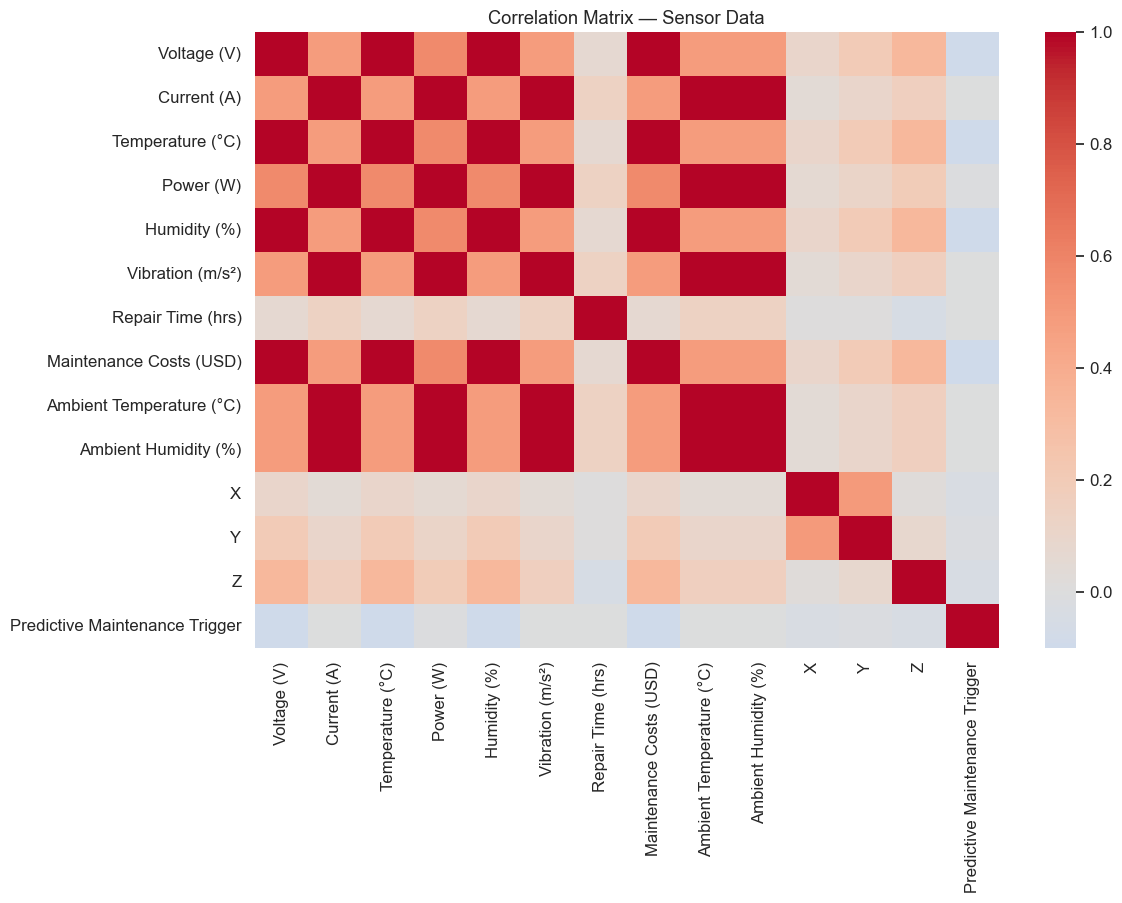

In [15]:
plt.figure(figsize=(12, 8))
sns.heatmap(sens[sensor_cols].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Matrix — Sensor Data")
plt.show()


Numeric Sensor Columns Being Plotted: ['Voltage (V)', 'Current (A)', 'Temperature (°C)', 'Power (W)', 'Humidity (%)']


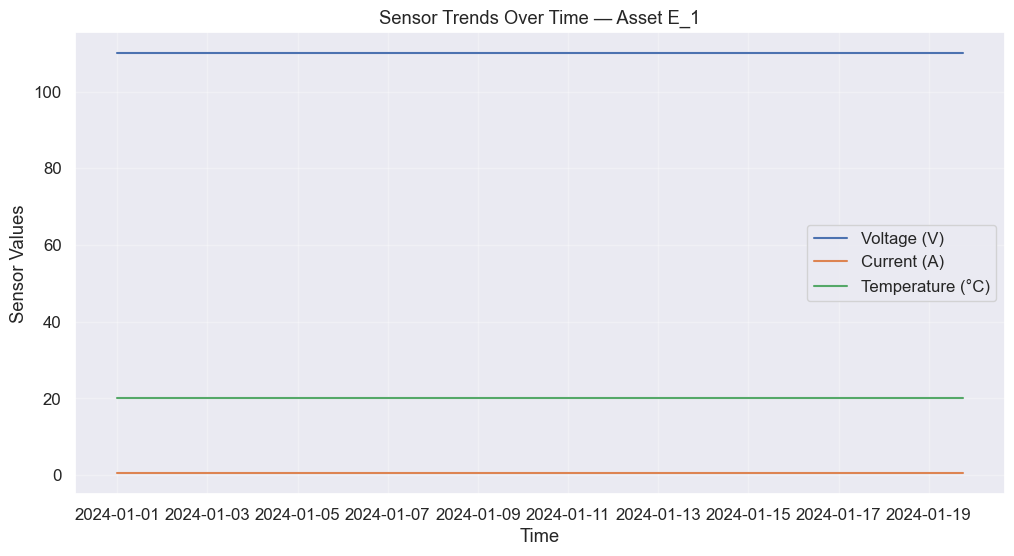

In [16]:
# Filter only numeric sensor columns (removes X, Y, Z, categorical, etc.)
numeric_sensor_cols = sens.select_dtypes(include=[np.number]).columns.tolist()

# Remove ID + failure flag + useless numeric fields
remove_cols = ["asset_id", "failure_flag"]
numeric_sensor_cols = [c for c in numeric_sensor_cols if c not in remove_cols]

print("Numeric Sensor Columns Being Plotted:", numeric_sensor_cols[:5])

# Choose an example asset
example_asset = sens["asset_id"].value_counts().index[0]
df_plot = sens[sens["asset_id"] == example_asset].sort_values("timestamp")

plt.figure(figsize=(12,6))

# Plot only numeric columns (this prevents crashes)
for col in numeric_sensor_cols[:3]:
    plt.plot(df_plot["timestamp"], df_plot[col], label=col)

plt.title(f"Sensor Trends Over Time — Asset {example_asset}")
plt.xlabel("Time")
plt.ylabel("Sensor Values")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


AHU Numeric Columns: ['CHWC_VLV', 'CHWC_VLV_DM', 'MA_TEMP', 'OA_CFM', 'OA_DMPR']


C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\2021888075.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=ahu, x="hour", y=col, estimator="mean", ci=None, label=col)
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\2021888075.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=ahu, x="hour", y=col, estimator="mean", ci=None, label=col)
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\2021888075.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=ahu, x="hour", y=col, estimator="mean", ci=None, label=col)


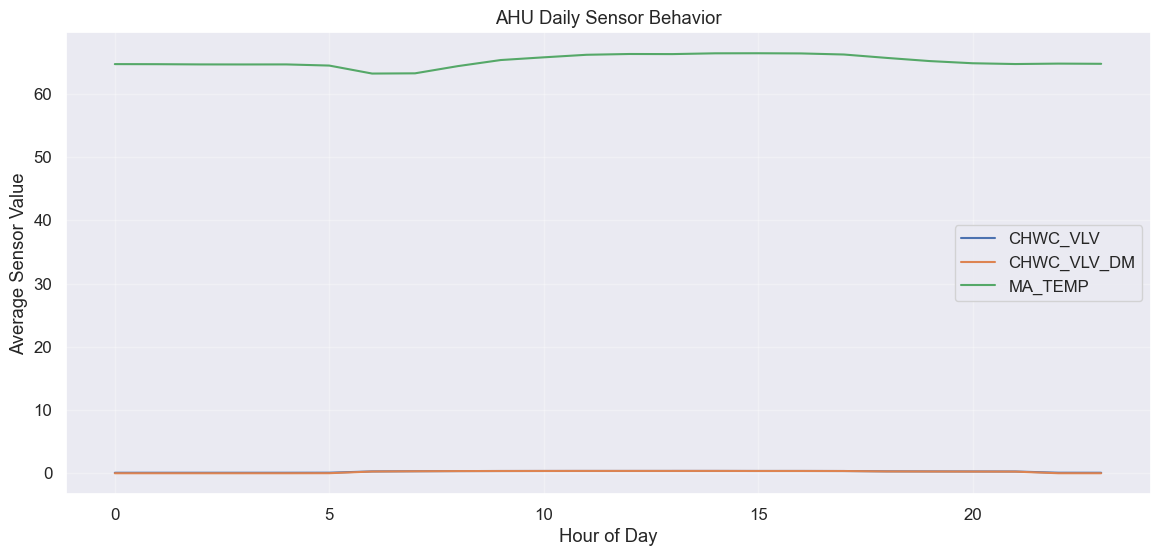

In [17]:
# Convert numeric columns only
ahu_numeric_cols = ahu.select_dtypes(include=[np.number]).columns.tolist()

# Remove metadata columns
remove_cols = ["hour"]
ahu_numeric_cols = [c for c in ahu_numeric_cols if c not in remove_cols]

print("AHU Numeric Columns:", ahu_numeric_cols[:5])

# Add hour column
ahu["hour"] = ahu["timestamp"].dt.hour

plt.figure(figsize=(14,6))

# Plot only numeric AHU sensor columns
for col in ahu_numeric_cols[:3]:
    sns.lineplot(data=ahu, x="hour", y=col, estimator="mean", ci=None, label=col)

plt.title("AHU Daily Sensor Behavior")
plt.xlabel("Hour of Day")
plt.ylabel("Average Sensor Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [18]:
# Ensure proper ordering
sens = sens.sort_values(["asset_id", "timestamp"])

# Set multi-index for time-series operations
sens = sens.set_index("timestamp")

sens.head()


,Sensor_ID,Voltage (V),Current (A),Temperature (°C),Power (W),Humidity (%),Vibration (m/s²),asset_id,Operational Status,Fault Status,Failure Type,Last Maintenance Date,Maintenance Type,Failure History,Repair Time (hrs),Maintenance Costs (USD),Ambient Temperature (°C),Ambient Humidity (%),External Factors,X,Y,Z,Equipment Relationship,Equipment Criticality,Fault Detected,Predictive Maintenance Trigger,failure_flag
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00,S_1,110,0.5,20,55.0,40,0.2,E_1,Operational,Fault Detected,Overload,2024-12-01,Preventive,Fault Detected,5,150,20,40,Clear Weather,0,0,0,Independent,High,1,1,1
2024-01-03 02:00:00,S_51,110,0.5,20,55.0,40,0.2,E_1,Operational,No Fault,Overheating,2024-12-01,Preventive,No Fault,0,150,20,40,Clear Weather,50,0,20,Dependent,High,0,0,0
2024-01-05 04:00:00,S_101,110,0.5,20,55.0,40,0.2,E_1,Operational,No Fault,Overload,2024-12-01,Preventive,No Fault,0,150,20,40,Clear Weather,0,0,10,Dependent,High,0,1,0
2024-01-07 06:00:00,S_151,110,0.5,20,55.0,40,0.2,E_1,Operational,Fault Detected,Overheating,2024-12-01,Preventive,Fault Detected,5,150,20,40,Clear Weather,50,0,0,Independent,High,1,0,1
2024-01-09 08:00:00,S_201,110,0.5,20,55.0,40,0.2,E_1,Operational,No Fault,Overload,2024-12-01,Preventive,No Fault,0,150,20,40,Clear Weather,0,0,20,Dependent,High,0,1,0


In [19]:
# Identify numeric sensor columns
numeric_cols = sens.select_dtypes(include=["number"]).columns.tolist()

# Remove labels / identifiers from feature candidates
exclude_cols = ["failure_flag"]
sensor_cols = [c for c in numeric_cols if c not in exclude_cols]

sensor_cols


['Voltage (V)',
 'Current (A)',
 'Temperature (°C)',
 'Power (W)',
 'Humidity (%)',
 'Vibration (m/s²)',
 'Repair Time (hrs)',
 'Maintenance Costs (USD)',
 'Ambient Temperature (°C)',
 'Ambient Humidity (%)',
 'X',
 'Y',
 'Z',
 'Fault Detected',
 'Predictive Maintenance Trigger']

In [20]:
# Aggregate raw data to hourly snapshots per asset
hourly = (
    sens
    .groupby("asset_id")[sensor_cols]
    .resample("1H")
    .mean()
    .reset_index()
)

hourly.head()


C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\3592860695.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H")


,asset_id,timestamp,Voltage (V),Current (A),Temperature (°C),Power (W),Humidity (%),Vibration (m/s²),Repair Time (hrs),Maintenance Costs (USD),Ambient Temperature (°C),Ambient Humidity (%),X,Y,Z,Fault Detected,Predictive Maintenance Trigger
0,E_1,2024-01-01 00:00:00,110.0,0.5,20.0,55.0,40.0,0.2,5.0,150.0,20.0,40.0,0.0,0.0,0.0,1.0,1.0
1,E_1,2024-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E_1,2024-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E_1,2024-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E_1,2024-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Check missing data after resampling
hourly.isna().mean().sort_values(ascending=False).head(10)


Voltage (V)                0.977827
Y                          0.977827
Current (A)                0.977827
Temperature (°C)           0.977827
Power (W)                  0.977827
Vibration (m/s²)           0.977827
Humidity (%)               0.977827
Repair Time (hrs)          0.977827
Maintenance Costs (USD)    0.977827
Fault Detected             0.977827
dtype: float64

In [22]:
# Forward-fill short gaps per asset
hourly[sensor_cols] = (
    hourly
    .groupby("asset_id")[sensor_cols]
    .ffill(limit=3)
)


In [23]:
print("Rows:", hourly.shape[0])
print("Assets:", hourly["asset_id"].nunique())
print("Time span:", hourly["timestamp"].min(), "→", hourly["timestamp"].max())

hourly.head()


Rows: 22550
Assets: 50
Time span: 2024-01-01 00:00:00 → 2024-01-21 19:00:00


,asset_id,timestamp,Voltage (V),Current (A),Temperature (°C),Power (W),Humidity (%),Vibration (m/s²),Repair Time (hrs),Maintenance Costs (USD),Ambient Temperature (°C),Ambient Humidity (%),X,Y,Z,Fault Detected,Predictive Maintenance Trigger
0,E_1,2024-01-01 00:00:00,110.0,0.5,20.0,55.0,40.0,0.2,5.0,150.0,20.0,40.0,0.0,0.0,0.0,1.0,1.0
1,E_1,2024-01-01 01:00:00,110.0,0.5,20.0,55.0,40.0,0.2,5.0,150.0,20.0,40.0,0.0,0.0,0.0,1.0,1.0
2,E_1,2024-01-01 02:00:00,110.0,0.5,20.0,55.0,40.0,0.2,5.0,150.0,20.0,40.0,0.0,0.0,0.0,1.0,1.0
3,E_1,2024-01-01 03:00:00,110.0,0.5,20.0,55.0,40.0,0.2,5.0,150.0,20.0,40.0,0.0,0.0,0.0,1.0,1.0
4,E_1,2024-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# Ensure correct sorting before rolling
hourly = hourly.sort_values(["asset_id", "timestamp"])

hourly.head()


,asset_id,timestamp,Voltage (V),Current (A),Temperature (°C),Power (W),Humidity (%),Vibration (m/s²),Repair Time (hrs),Maintenance Costs (USD),Ambient Temperature (°C),Ambient Humidity (%),X,Y,Z,Fault Detected,Predictive Maintenance Trigger
0,E_1,2024-01-01 00:00:00,110.0,0.5,20.0,55.0,40.0,0.2,5.0,150.0,20.0,40.0,0.0,0.0,0.0,1.0,1.0
1,E_1,2024-01-01 01:00:00,110.0,0.5,20.0,55.0,40.0,0.2,5.0,150.0,20.0,40.0,0.0,0.0,0.0,1.0,1.0
2,E_1,2024-01-01 02:00:00,110.0,0.5,20.0,55.0,40.0,0.2,5.0,150.0,20.0,40.0,0.0,0.0,0.0,1.0,1.0
3,E_1,2024-01-01 03:00:00,110.0,0.5,20.0,55.0,40.0,0.2,5.0,150.0,20.0,40.0,0.0,0.0,0.0,1.0,1.0
4,E_1,2024-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Ensure correct sorting before rolling
hourly = hourly.sort_values(["asset_id", "timestamp"])

hourly.head()


,asset_id,timestamp,Voltage (V),Current (A),Temperature (°C),Power (W),Humidity (%),Vibration (m/s²),Repair Time (hrs),Maintenance Costs (USD),Ambient Temperature (°C),Ambient Humidity (%),X,Y,Z,Fault Detected,Predictive Maintenance Trigger
0,E_1,2024-01-01 00:00:00,110.0,0.5,20.0,55.0,40.0,0.2,5.0,150.0,20.0,40.0,0.0,0.0,0.0,1.0,1.0
1,E_1,2024-01-01 01:00:00,110.0,0.5,20.0,55.0,40.0,0.2,5.0,150.0,20.0,40.0,0.0,0.0,0.0,1.0,1.0
2,E_1,2024-01-01 02:00:00,110.0,0.5,20.0,55.0,40.0,0.2,5.0,150.0,20.0,40.0,0.0,0.0,0.0,1.0,1.0
3,E_1,2024-01-01 03:00:00,110.0,0.5,20.0,55.0,40.0,0.2,5.0,150.0,20.0,40.0,0.0,0.0,0.0,1.0,1.0
4,E_1,2024-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# Rolling window sizes (in hours)
rolling_windows = {
    "1h": 1,
    "6h": 6,
    "24h": 24
}


In [29]:
# Create a copy to store features
features = hourly.copy()

for window_name, window_size in rolling_windows.items():
    for col in sensor_cols:
        features[f"{col}_mean_{window_name}"] = (
            hourly
            .groupby("asset_id")[col]
            .rolling(window=window_size, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
        )

        features[f"{col}_std_{window_name}"] = (
            hourly
            .groupby("asset_id")[col]
            .rolling(window=window_size, min_periods=1)
            .std()
            .reset_index(level=0, drop=True)
        )

        features[f"{col}_min_{window_name}"] = (
            hourly
            .groupby("asset_id")[col]
            .rolling(window=window_size, min_periods=1)
            .min()
            .reset_index(level=0, drop=True)
        )

        features[f"{col}_max_{window_name}"] = (
            hourly
            .groupby("asset_id")[col]
            .rolling(window=window_size, min_periods=1)
            .max()
            .reset_index(level=0, drop=True)
        )



C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\814413283.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f"{col}_std_{window_name}"] = (
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\814413283.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f"{col}_min_{window_name}"] = (
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\814413283.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

In [30]:
for window_name, window_size in rolling_windows.items():
    for col in sensor_cols:
        features[f"{col}_range_{window_name}"] = (
            features[f"{col}_max_{window_name}"] -
            features[f"{col}_min_{window_name}"]
        )

        features[f"{col}_median_{window_name}"] = (
            hourly
            .groupby("asset_id")[col]
            .rolling(window=window_size, min_periods=1)
            .median()
            .reset_index(level=0, drop=True)
        )


C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\4133140681.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f"{col}_range_{window_name}"] = (
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\4133140681.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f"{col}_median_{window_name}"] = (
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\4133140681.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

In [31]:
percentiles = {
    "p25": 0.25,
    "p75": 0.75,
    "p90": 0.90
}

for window_name, window_size in rolling_windows.items():
    for col in sensor_cols:
        for p_name, p_value in percentiles.items():
            features[f"{col}_{p_name}_{window_name}"] = (
                hourly
                .groupby("asset_id")[col]
                .rolling(window=window_size, min_periods=1)
                .quantile(p_value)
                .reset_index(level=0, drop=True)
            )


C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\1434277442.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f"{col}_{p_name}_{window_name}"] = (
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\1434277442.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f"{col}_{p_name}_{window_name}"] = (
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\1434277442.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 

In [32]:
for window_name in rolling_windows.keys():
    for col in sensor_cols:
        features[f"{col}_cv_{window_name}"] = (
            features[f"{col}_std_{window_name}"] /
            (features[f"{col}_mean_{window_name}"] + 1e-6)
        )


C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\1074576374.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f"{col}_cv_{window_name}"] = (
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\1074576374.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f"{col}_cv_{window_name}"] = (
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\1074576374.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

In [33]:
print("Feature table shape:", features.shape)
features.head()


Feature table shape: (22550, 467)


,asset_id,timestamp,Voltage (V),Current (A),Temperature (°C),Power (W),Humidity (%),Vibration (m/s²),Repair Time (hrs),Maintenance Costs (USD),Ambient Temperature (°C),Ambient Humidity (%),X,Y,Z,Fault Detected,Predictive Maintenance Trigger,Voltage (V)_mean_1h,Voltage (V)_std_1h,Voltage (V)_min_1h,Voltage (V)_max_1h,Current (A)_mean_1h,Current (A)_std_1h,Current (A)_min_1h,Current (A)_max_1h,Temperature (°C)_mean_1h,Temperature (°C)_std_1h,Temperature (°C)_min_1h,Temperature (°C)_max_1h,Power (W)_mean_1h,Power (W)_std_1h,Power (W)_min_1h,Power (W)_max_1h,Humidity (%)_mean_1h,Humidity (%)_std_1h,Humidity (%)_min_1h,Humidity (%)_max_1h,Vibration (m/s²)_mean_1h,Vibration (m/s²)_std_1h,Vibration (m/s²)_min_1h,Vibration (m/s²)_max_1h,Repair Time (hrs)_mean_1h,Repair Time (hrs)_std_1h,Repair Time (hrs)_min_1h,Repair Time (hrs)_max_1h,Maintenance Costs (USD)_mean_1h,Maintenance Costs (USD)_std_1h,Maintenance Costs (USD)_min_1h,Maintenance Costs (USD)_max_1h,Ambient Temperature (°C)_mean_1h,Ambient Temperature (°C)_std_1h,Ambient Temperature (°C)_min_1h,Ambient Temperature (°C)_max_1h,Ambient Humidity (%)_mean_1h,Ambient Humidity (%)_std_1h,Ambient Humidity (%)_min_1h,Ambient Humidity (%)_max_1h,X_mean_1h,X_std_1h,X_min_1h,X_max_1h,Y_mean_1h,Y_std_1h,Y_min_1h,Y_max_1h,Z_mean_1h,Z_std_1h,Z_min_1h,Z_max_1h,Fault Detected_mean_1h,Fault Detected_std_1h,Fault Detected_min_1h,Fault Detected_max_1h,Predictive Maintenance Trigger_mean_1h,Predictive Maintenance Trigger_std_1h,Predictive Maintenance Trigger_min_1h,Predictive Maintenance Trigger_max_1h,Voltage (V)_mean_6h,Voltage (V)_std_6h,Voltage (V)_min_6h,Voltage (V)_max_6h,Current (A)_mean_6h,Current (A)_std_6h,Current (A)_min_6h,Current (A)_max_6h,Temperature (°C)_mean_6h,Temperature (°C)_std_6h,Temperature (°C)_min_6h,Temperature (°C)_max_6h,Power (W)_mean_6h,Power (W)_std_6h,Power (W)_min_6h,Power (W)_max_6h,Humidity (%)_mean_6h,Humidity (%)_std_6h,Humidity (%)_min_6h,Humidity (%)_max_6h,Vibration (m/s²)_mean_6h,Vibration (m/s²)_std_6h,Vibration (m/s²)_min_6h,Vibration (m/s²)_max_6h,Repair Time (hrs)_mean_6h,Repair Time (hrs)_std_6h,Repair Time (hrs)_min_6h,Repair Time (hrs)_max_6h,Maintenance Costs (USD)_mean_6h,Maintenance Costs (USD)_std_6h,Maintenance Costs (USD)_min_6h,Maintenance Costs (USD)_max_6h,Ambient Temperature (°C)_mean_6h,Ambient Temperature (°C)_std_6h,Ambient Temperature (°C)_min_6h,Ambient Temperature (°C)_max_6h,Ambient Humidity (%)_mean_6h,Ambient Humidity (%)_std_6h,Ambient Humidity (%)_min_6h,Ambient Humidity (%)_max_6h,X_mean_6h,X_std_6h,X_min_6h,X_max_6h,Y_mean_6h,Y_std_6h,Y_min_6h,Y_max_6h,Z_mean_6h,Z_std_6h,Z_min_6h,Z_max_6h,Fault Detected_mean_6h,Fault Detected_std_6h,Fault Detected_min_6h,Fault Detected_max_6h,Predictive Maintenance Trigger_mean_6h,Predictive Maintenance Trigger_std_6h,Predictive Maintenance Trigger_min_6h,Predictive Maintenance Trigger_max_6h,Voltage (V)_mean_24h,Voltage (V)_std_24h,Voltage (V)_min_24h,Voltage (V)_max_24h,Current (A)_mean_24h,Current (A)_std_24h,Current (A)_min_24h,Current (A)_max_24h,Temperature (°C)_mean_24h,Temperature (°C)_std_24h,Temperature (°C)_min_24h,Temperature (°C)_max_24h,Power (W)_mean_24h,Power (W)_std_24h,Power (W)_min_24h,Power (W)_max_24h,Humidity (%)_mean_24h,Humidity (%)_std_24h,Humidity (%)_min_24h,Humidity (%)_max_24h,Vibration (m/s²)_mean_24h,Vibration (m/s²)_std_24h,Vibration (m/s²)_min_24h,Vibration (m/s²)_max_24h,Repair Time (hrs)_mean_24h,Repair Time (hrs)_std_24h,Repair Time (hrs)_min_24h,Repair Time (hrs)_max_24h,Maintenance Costs (USD)_mean_24h,Maintenance Costs (USD)_std_24h,Maintenance Costs (USD)_min_24h,Maintenance Costs (USD)_max_24h,Ambient Temperature (°C)_mean_24h,Ambient Temperature (°C)_std_24h,Ambient Temperature (°C)_min_24h,Ambient Temperature (°C)_max_24h,Ambient Humidity (%)_mean_24h,Ambient Humidity (%)_std_24h,Ambient Humidity (%)_min_24h,Ambient Humidity (%)_max_24h,X_mean_24h,X_std_24h,X_min_24h,X_max_24h,Y_mean_24h,Y_std_24h,Y_min_24h,Y_max_24h,Z_mean_24h,Z_std_24h,Z_min_24h,Z_

In [34]:
len(features.columns)


467

In [35]:
hourly = hourly.sort_values(["asset_id", "timestamp"]).copy()


In [36]:
for col in sensor_cols:
    features[f"{col}_d1"] = hourly.groupby("asset_id")[col].diff(1)


C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\3259005614.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f"{col}_d1"] = hourly.groupby("asset_id")[col].diff(1)
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\3259005614.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f"{col}_d1"] = hourly.groupby("asset_id")[col].diff(1)
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\3259005614.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

In [37]:
for col in sensor_cols:
    features[f"{col}_d2"] = features.groupby("asset_id")[f"{col}_d1"].diff(1)


C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\653964953.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f"{col}_d2"] = features.groupby("asset_id")[f"{col}_d1"].diff(1)
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\653964953.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f"{col}_d2"] = features.groupby("asset_id")[f"{col}_d1"].diff(1)
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\653964953.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fram

In [38]:
trend_windows = {
    "6h": 6,
    "24h": 24
}

for window_name, w in trend_windows.items():
    for col in sensor_cols:
        first_val = hourly.groupby("asset_id")[col].shift(w-1)
        last_val  = hourly[col]
        features[f"{col}_slope_{window_name}"] = (last_val - first_val) / max(w-1, 1)


C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\2988788583.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f"{col}_slope_{window_name}"] = (last_val - first_val) / max(w-1, 1)
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\2988788583.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f"{col}_slope_{window_name}"] = (last_val - first_val) / max(w-1, 1)
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\2988788583.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

In [39]:
# Threshold to decide if "stable" (tune later)
EPS = 1e-3

for window_name in trend_windows.keys():
    for col in sensor_cols:
        slope_col = f"{col}_slope_{window_name}"
        
        features[f"{col}_trend_{window_name}"] = np.where(
            features[slope_col] > EPS, "increasing",
            np.where(features[slope_col] < -EPS, "decreasing", "stable")
        )


C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\1865132230.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f"{col}_trend_{window_name}"] = np.where(
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\1865132230.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f"{col}_trend_{window_name}"] = np.where(
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\1865132230.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfor

In [40]:
for window_name, w in trend_windows.items():
    for col in sensor_cols:
        features[f"{col}_d1_std_{window_name}"] = (
            features
            .groupby("asset_id")[f"{col}_d1"]
            .rolling(w, min_periods=1)
            .std()
            .reset_index(level=0, drop=True)
        )


C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\2298286304.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f"{col}_d1_std_{window_name}"] = (
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\2298286304.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f"{col}_d1_std_{window_name}"] = (
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\2298286304.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

In [41]:
print("Features shape after Step 3:", features.shape)
features[[ "asset_id", "timestamp" ] + [f"{sensor_cols[0]}_d1", f"{sensor_cols[0]}_d2", f"{sensor_cols[0]}_slope_6h", f"{sensor_cols[0]}_trend_6h"]].head(10)


Features shape after Step 3: (22550, 587)


,asset_id,timestamp,Voltage (V)_d1,Voltage (V)_d2,Voltage (V)_slope_6h,Voltage (V)_trend_6h
0,E_1,2024-01-01 00:00:00,NaN,NaN,NaN,stable
1,E_1,2024-01-01 01:00:00,0.0,NaN,NaN,stable
2,E_1,2024-01-01 02:00:00,0.0,0.0,NaN,stable
3,E_1,2024-01-01 03:00:00,0.0,0.0,NaN,stable
4,E_1,2024-01-01 04:00:00,NaN,NaN,NaN,stable
5,E_1,2024-01-01 05:00:00,NaN,NaN,NaN,stable
6,E_1,2024-01-01 06:00:00,NaN,NaN,NaN,stable
7,E_1,2024-01-01 07:00:00,NaN,NaN,NaN,stable
8,E_1,2024-01-01 08:00:00,NaN,NaN,NaN,stable
9,E_1,2024-01-01 09:00:00,NaN,NaN,NaN,stable


In [42]:
# Expected electrical power (proxy)
features["expected_power"] = (
    hourly["Voltage (V)"] * hourly["Current (A)"]
)

# Energy anomaly (normalized)
features["power_anomaly"] = (
    features["Power (W)"] - features["expected_power"]
) / (features["expected_power"] + 1e-6)


C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\1695549980.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features["expected_power"] = (
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\1695549980.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features["power_anomaly"] = (


In [43]:
# Temperature stress relative to recent mean
features["thermal_stress"] = (
    features["Temperature (°C)"] -
    features["Temperature (°C)_mean_24h"]
)


C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\1316067010.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features["thermal_stress"] = (


In [44]:
# Optional ambient normalization
if "Ambient Temperature (°C)" in features.columns:
    features["thermal_delta_ambient"] = (
        features["Temperature (°C)"] -
        features["Ambient Temperature (°C)"]
    )


C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\2907860747.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features["thermal_delta_ambient"] = (


In [45]:
# Rolling vibration growth indicator
features["vibration_trend"] = features["Vibration (m/s²)_slope_24h"]

# Vibration instability
features["vibration_instability"] = features["Vibration (m/s²)_cv_24h"]


C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\99104103.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features["vibration_trend"] = features["Vibration (m/s²)_slope_24h"]
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\99104103.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features["vibration_instability"] = features["Vibration (m/s²)_cv_24h"]


In [46]:
features["power_deviation"] = (
    features["Power (W)"] -
    features["Power (W)_mean_6h"]
) / (features["Power (W)_mean_6h"] + 1e-6)


C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\3243634235.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features["power_deviation"] = (


In [47]:
from sklearn.preprocessing import MinMaxScaler

degradation_cols = [
    "power_anomaly",
    "thermal_stress",
    "vibration_trend",
    "vibration_instability",
    "power_deviation"
]

scaler = MinMaxScaler()

features[[f"{c}_norm" for c in degradation_cols]] = scaler.fit_transform(
    features[degradation_cols].fillna(0)
)


C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\4239580404.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[[f"{c}_norm" for c in degradation_cols]] = scaler.fit_transform(
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\4239580404.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[[f"{c}_norm" for c in degradation_cols]] = scaler.fit_transform(
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\4239580404.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

In [48]:
features["health_index"] = 100 * (
    1 -
    (
        0.30 * features["vibration_trend_norm"] +
        0.25 * features["vibration_instability_norm"] +
        0.20 * features["thermal_stress_norm"] +
        0.15 * features["power_anomaly_norm"] +
        0.10 * features["power_deviation_norm"]
    )
)

# Clip to [0, 100]
features["health_index"] = features["health_index"].clip(0, 100)


C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\3798154882.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features["health_index"] = 100 * (


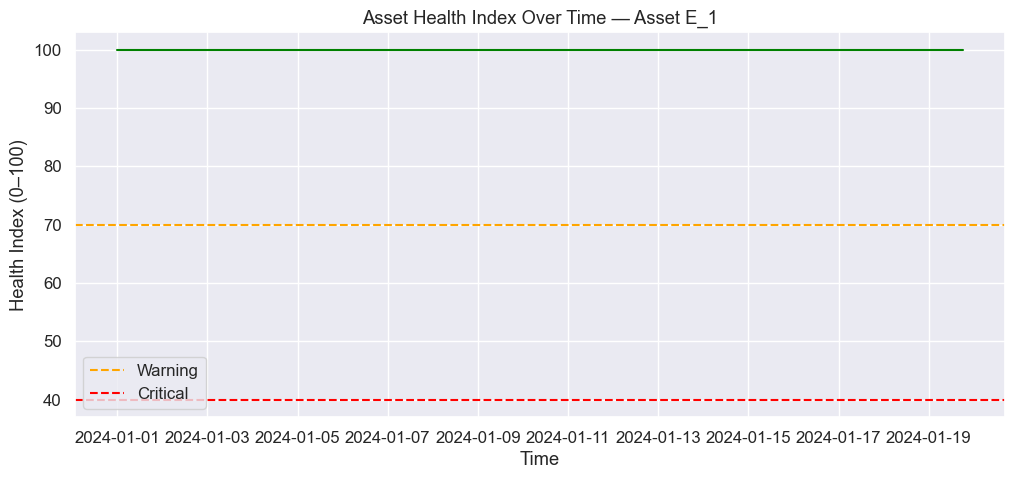

In [49]:
example_asset = features["asset_id"].value_counts().index[0]
df_health = features[features["asset_id"] == example_asset]

plt.figure(figsize=(12,5))
plt.plot(df_health["timestamp"], df_health["health_index"], color="green")
plt.axhline(70, color="orange", linestyle="--", label="Warning")
plt.axhline(40, color="red", linestyle="--", label="Critical")

plt.title(f"Asset Health Index Over Time — Asset {example_asset}")
plt.xlabel("Time")
plt.ylabel("Health Index (0–100)")
plt.legend()
plt.show()


In [50]:
# Start from original sensor dataset (before resampling) if you still have it:
# If sens currently has timestamp as index, bring it back as a column first.
sens_reset = sens.reset_index()

# Convert maintenance date to datetime if present
if "Last Maintenance Date" in sens_reset.columns:
    sens_reset["Last Maintenance Date"] = pd.to_datetime(sens_reset["Last Maintenance Date"], errors="coerce")

    # For each asset, track most recent maintenance date observed up to each timestamp
    sens_reset = sens_reset.sort_values(["asset_id", "timestamp"])
    sens_reset["last_maint_running"] = (
        sens_reset.groupby("asset_id")["Last Maintenance Date"]
        .ffill()
    )

    # Build a small table at hourly timestamps to merge with feature table
    maint_hourly = (
        sens_reset[["asset_id", "timestamp", "last_maint_running"]]
        .drop_duplicates(subset=["asset_id", "timestamp"])
        .sort_values(["asset_id", "timestamp"])
    )

    # Merge into features
    features = features.merge(maint_hourly, on=["asset_id", "timestamp"], how="left")
    features["last_maint_running"] = features.groupby("asset_id")["last_maint_running"].ffill()

    features["days_since_maintenance"] = (
        (features["timestamp"] - features["last_maint_running"]).dt.total_seconds() / (3600 * 24)
    )

    print("days_since_maintenance created ✅")
else:
    print("No 'Last Maintenance Date' column found — skipping maintenance context.")


days_since_maintenance created ✅


In [51]:
# Load proxy (using power as a load indicator)
if "Power (W)" in features.columns:
    features["load_proxy"] = features["Power (W)"] / (features["Power (W)_mean_24h"] + 1e-6)

# Ambient normalization if present
if "Ambient Temperature (°C)" in features.columns and "Temperature (°C)" in features.columns:
    features["temp_minus_ambient"] = features["Temperature (°C)"] - features["Ambient Temperature (°C)"]

if "Ambient Humidity (%)" in features.columns and "Humidity (%)" in features.columns:
    features["humidity_minus_ambient"] = features["Humidity (%)"] - features["Ambient Humidity (%)"]

print("Context features added ✅")


Context features added ✅


In [52]:
lags_hours = {
    "lag_1d": 24,
    "lag_2d": 48,
    "lag_3d": 72,
    "lag_7d": 168,
    "lag_14d": 336,
    "lag_30d": 720
}

# Pick a limited set of "high-value" columns to lag
lag_base_cols = []
for c in ["Vibration (m/s²)", "Temperature (°C)", "Power (W)", "Voltage (V)", "Current (A)", "health_index"]:
    if c in features.columns:
        lag_base_cols.append(c)

print("Lagging columns:", lag_base_cols)

features = features.sort_values(["asset_id", "timestamp"])

for lag_name, lag_steps in lags_hours.items():
    for col in lag_base_cols:
        features[f"{col}_{lag_name}"] = features.groupby("asset_id")[col].shift(lag_steps)

print("Lag features created ✅")


Lagging columns: ['Vibration (m/s²)', 'Temperature (°C)', 'Power (W)', 'Voltage (V)', 'Current (A)', 'health_index']
Lag features created ✅


In [53]:
if "health_index" in features.columns:
    features["health_change_1d"] = features["health_index"] - features.groupby("asset_id")["health_index"].shift(24)
    features["health_change_7d"] = features["health_index"] - features.groupby("asset_id")["health_index"].shift(168)

if "Vibration (m/s²)" in features.columns:
    features["vib_change_1d"] = features["Vibration (m/s²)"] - features.groupby("asset_id")["Vibration (m/s²)"].shift(24)
    features["vib_change_7d"] = features["Vibration (m/s²)"] - features.groupby("asset_id")["Vibration (m/s²)"].shift(168)

if "Power (W)" in features.columns:
    features["power_change_1d"] = features["Power (W)"] - features.groupby("asset_id")["Power (W)"].shift(24)
    features["power_change_7d"] = features["Power (W)"] - features.groupby("asset_id")["Power (W)"].shift(168)

print("DoD/WoW features added ✅")


DoD/WoW features added ✅


In [54]:
features[[c for c in features.columns if "lag_" in c]].isna().mean().sort_values(ascending=False).head(10)


Vibration (m/s²)_lag_30d    1.000000
Temperature (°C)_lag_30d    1.000000
health_index_lag_30d        1.000000
Current (A)_lag_30d         1.000000
Voltage (V)_lag_30d         1.000000
Power (W)_lag_30d           1.000000
Vibration (m/s²)_lag_14d    0.973392
Voltage (V)_lag_14d         0.973392
Temperature (°C)_lag_14d    0.973392
Current (A)_lag_14d         0.973392
dtype: float64

In [57]:
features.to_csv("phase2_features.csv", index=False)
print("Saved phase2_features.csv ✅")


Saved phase2_features.csv ✅


In [58]:
# If sens is currently indexed by timestamp, bring it back
sens_reset = sens.reset_index() if "timestamp" not in sens.columns else sens.copy()

# Ensure correct types
sens_reset["timestamp"] = pd.to_datetime(sens_reset["timestamp"], errors="coerce")

# Create hourly label by taking max within each hour (if any fault in that hour => 1)
label_hourly = (
    sens_reset
    .assign(timestamp=sens_reset["timestamp"].dt.floor("H"))
    .groupby(["asset_id", "timestamp"], as_index=False)["failure_flag"]
    .max()
)

label_hourly.head()


C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\1906975376.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .assign(timestamp=sens_reset["timestamp"].dt.floor("H"))


,asset_id,timestamp,failure_flag
0,E_1,2024-01-01 00:00:00,1
1,E_1,2024-01-03 02:00:00,0
2,E_1,2024-01-05 04:00:00,0
3,E_1,2024-01-07 06:00:00,1
4,E_1,2024-01-09 08:00:00,0


In [59]:
# Ensure timestamp is datetime
features["timestamp"] = pd.to_datetime(features["timestamp"], errors="coerce")

# Merge label into features
model_df = features.merge(label_hourly, on=["asset_id", "timestamp"], how="left")

# If an hour has no label observation, assume 0 (no fault recorded)
model_df["failure_flag"] = model_df["failure_flag"].fillna(0).astype(int)

model_df[["asset_id", "timestamp", "failure_flag"]].head()


,asset_id,timestamp,failure_flag
0,E_1,2024-01-01 00:00:00,1
1,E_1,2024-01-01 01:00:00,0
2,E_1,2024-01-01 02:00:00,0
3,E_1,2024-01-01 03:00:00,0
4,E_1,2024-01-01 04:00:00,0


In [60]:
# Keep keys
key_cols = ["asset_id", "timestamp", "failure_flag"]

# Keep only numeric columns (model features)
numeric_feature_cols = model_df.select_dtypes(include=[np.number]).columns.tolist()

# Ensure failure_flag is included and keys exist
keep_cols = list(dict.fromkeys(key_cols + numeric_feature_cols))  # unique preserve order

model_df = model_df[keep_cols].copy()

model_df.shape


(22550, 617)

In [61]:
# Drop rows missing critical long-window features (choose a few anchors)
critical_cols = []

# Add a few strong anchor features if present
for c in [
    "Vibration (m/s²)_mean_24h",
    "Temperature (°C)_mean_24h",
    "Power (W)_mean_24h",
    "health_index"
]:
    if c in model_df.columns:
        critical_cols.append(c)

print("Critical columns used for dropping rows:", critical_cols)

model_df_clean = model_df.dropna(subset=critical_cols).copy()

print("Before:", model_df.shape)
print("After :", model_df_clean.shape)


Critical columns used for dropping rows: ['Vibration (m/s²)_mean_24h', 'Temperature (°C)_mean_24h', 'Power (W)_mean_24h', 'health_index']
Before: (22550, 617)
After : (12200, 617)


In [62]:
print("Failure flag distribution:")
print(model_df_clean["failure_flag"].value_counts(dropna=False))
print("\nFailure rate:", model_df_clean["failure_flag"].mean())


Failure flag distribution:
failure_flag
0    12033
1      167
Name: count, dtype: int64

Failure rate: 0.013688524590163934


In [63]:
model_df_clean.to_csv("phase2_model_ready.csv", index=False)
print("Saved: phase2_model_ready.csv ✅")


Saved: phase2_model_ready.csv ✅


In [64]:
df = model_df_clean.copy()   # <- change to model_df_imputed if needed

# Identify numeric feature columns (exclude label)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_feature_cols = [c for c in num_cols if c != "failure_flag"]

print("Numeric feature columns:", len(num_feature_cols))
df[["failure_flag"]].value_counts()


Numeric feature columns: 614


failure_flag
0               12033
1                 167
Name: count, dtype: int64

In [65]:
corr_with_fail = df[num_feature_cols].corrwith(df["failure_flag"]).sort_values(ascending=False)

corr_table = (
    corr_with_fail
    .dropna()
    .to_frame(name="pearson_corr_with_failure")
)

# Add absolute correlation for ranking
corr_table["abs_corr"] = corr_table["pearson_corr_with_failure"].abs()
corr_table = corr_table.sort_values("abs_corr", ascending=False)

corr_table.head(20)


C:\Users\mihir\anaconda3\envs\myenv\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\mihir\anaconda3\envs\myenv\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,pearson_corr_with_failure,abs_corr
Fault Detected_mean_1h,0.445303,0.445303
Fault Detected_p90_1h,0.445303,0.445303
Fault Detected_p25_1h,0.445303,0.445303
Fault Detected_min_1h,0.445303,0.445303
Fault Detected_p75_1h,0.445303,0.445303
Fault Detected_max_1h,0.445303,0.445303
Fault Detected_median_1h,0.445303,0.445303
Fault Detected,0.445303,0.445303
Repair Time (hrs)_p25_1h,0.431842,0.431842
Repair Time (hrs)_p75_1h,0.431842,0.431842


In [66]:
corr_table.to_csv("phase2_feature_failure_correlations.csv", index=True)
print("Saved: phase2_feature_failure_correlations.csv ✅")


Saved: phase2_feature_failure_correlations.csv ✅


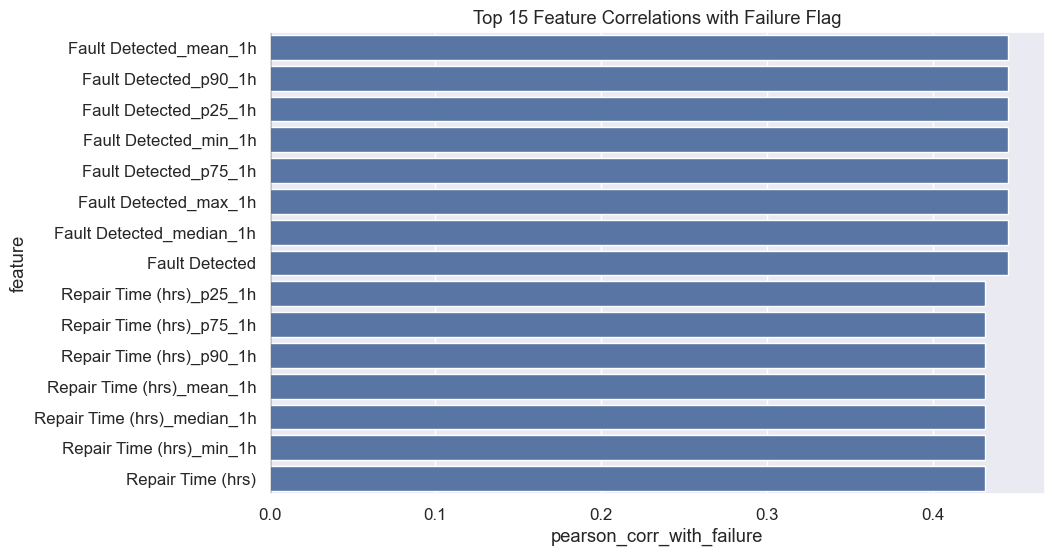

In [67]:
top_n = 15
top_features = corr_table.head(top_n).reset_index().rename(columns={"index": "feature"})

plt.figure(figsize=(10,6))
sns.barplot(data=top_features, x="pearson_corr_with_failure", y="feature")
plt.title(f"Top {top_n} Feature Correlations with Failure Flag")
plt.axvline(0, color="black", linewidth=1)
plt.show()


In [68]:
candidate_plot_features = []

# Prefer interpretable features if they exist
preferred = [
    "health_index",
    "Vibration (m/s²)",
    "Vibration (m/s²)_mean_24h",
    "Vibration (m/s²)_slope_24h",
    "Temperature (°C)",
    "Temperature (°C)_mean_24h",
    "power_anomaly",
    "thermal_stress",
    "Power (W)",
    "Power (W)_mean_24h"
]

for f in preferred:
    if f in df.columns and f in num_feature_cols:
        candidate_plot_features.append(f)

# If not enough preferred features, use top correlated features
if len(candidate_plot_features) < 3:
    candidate_plot_features = corr_table.head(5).index.tolist()

candidate_plot_features = candidate_plot_features[:5]
candidate_plot_features


['health_index',
 'Vibration (m/s²)',
 'Vibration (m/s²)_mean_24h',
 'Vibration (m/s²)_slope_24h',
 'Temperature (°C)']

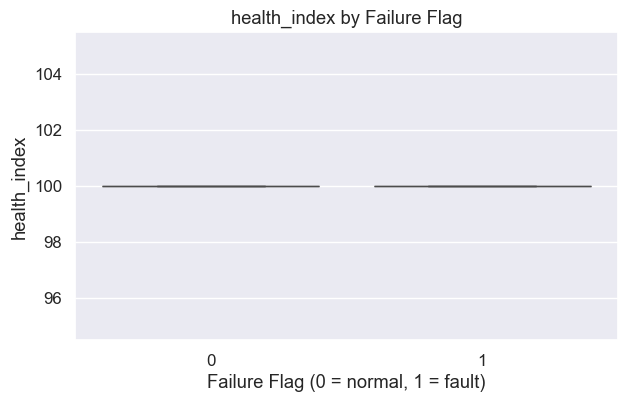

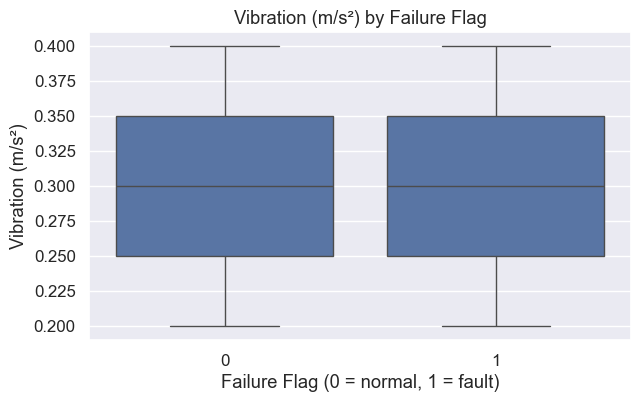

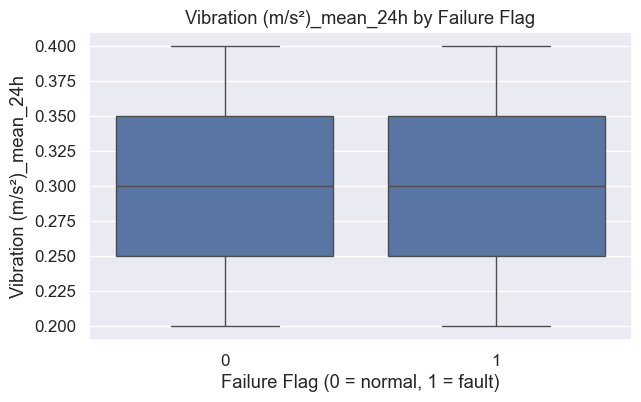

ValueError: List of boxplot statistics and `positions` values must have same the length

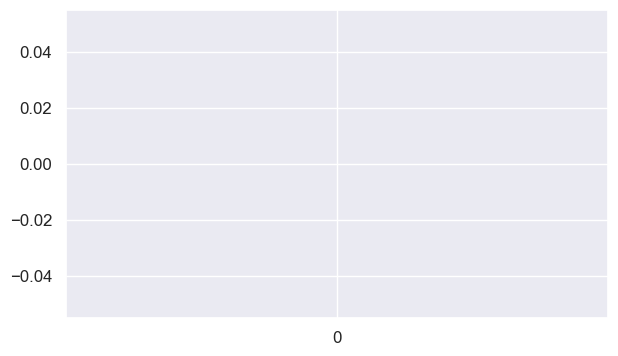

In [69]:
for feat in candidate_plot_features:
    plt.figure(figsize=(7,4))
    sns.boxplot(x="failure_flag", y=feat, data=df)
    plt.title(f"{feat} by Failure Flag")
    plt.xlabel("Failure Flag (0 = normal, 1 = fault)")
    plt.show()


C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\2718907401.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x="health_index", hue="failure_flag", common_norm=False)


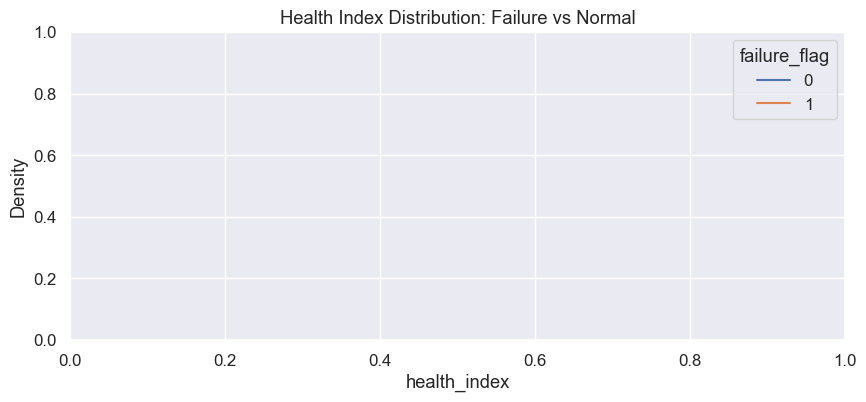

In [70]:
if "health_index" in df.columns:
    plt.figure(figsize=(10,4))
    sns.kdeplot(data=df, x="health_index", hue="failure_flag", common_norm=False)
    plt.title("Health Index Distribution: Failure vs Normal")
    plt.show()


In [71]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

df = model_df_clean.copy()

# Target
y = df["failure_flag"]

# Drop non-feature columns
drop_cols = ["failure_flag", "asset_id", "timestamp"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns])

print("Feature matrix shape:", X.shape)
print("Failure rate:", y.mean())


Feature matrix shape: (12200, 614)
Failure rate: 0.013688524590163934


In [72]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)


Train size: (9150, 614)
Validation size: (3050, 614)


In [73]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=50,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf.fit(X_train, y_train)

print("Model trained ✅")


Model trained ✅


In [74]:
importances = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
})

importances = importances.sort_values("importance", ascending=False)
importances.head(20)


,feature,importance
326,Fault Detected_p90_1h,0.059599
70,Fault Detected_max_1h,0.047481
304,Repair Time (hrs)_p75_1h,0.046835
6,Repair Time (hrs),0.045639
69,Fault Detected_min_1h,0.045330
13,Fault Detected,0.039808
222,Fault Detected_median_1h,0.033322
303,Repair Time (hrs)_p25_1h,0.031766
42,Repair Time (hrs)_max_1h,0.030470
67,Fault Detected_mean_1h,0.029698


In [75]:
importances.to_csv("phase2_feature_importance_rf.csv", index=False)
print("Saved: phase2_feature_importance_rf.csv ✅")


Saved: phase2_feature_importance_rf.csv ✅


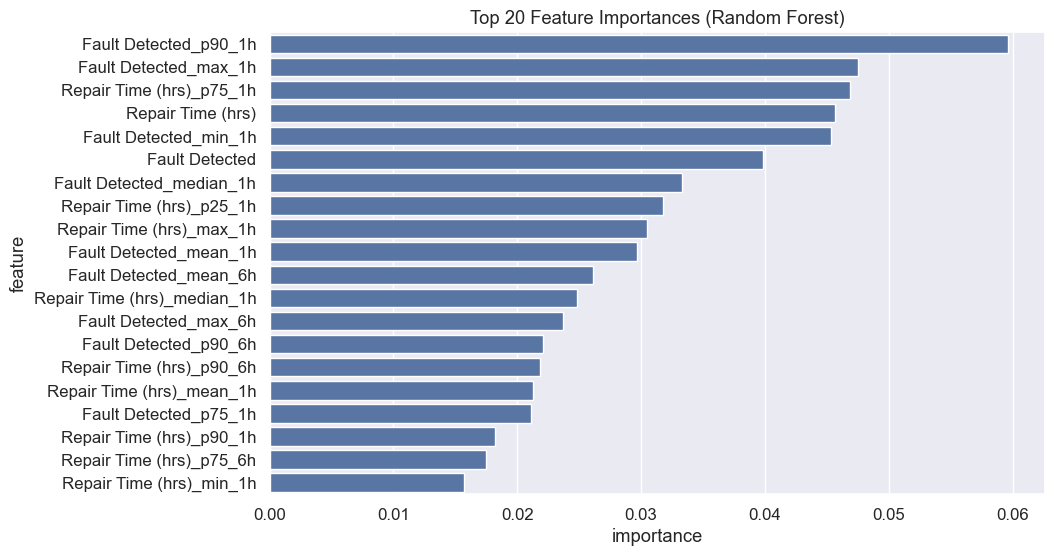

In [76]:
top_n = 20
top_imp = importances.head(top_n)

plt.figure(figsize=(10,6))
sns.barplot(data=top_imp, x="importance", y="feature")
plt.title("Top 20 Feature Importances (Random Forest)")
plt.show()


In [77]:
from sklearn.metrics import roc_auc_score

y_val_pred = rf.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val, y_val_pred)

print("Validation ROC-AUC:", round(auc, 3))


Validation ROC-AUC: 0.993


In [78]:
import re

df = model_df_clean.copy()

# Features are all columns except keys/label
exclude = {"asset_id", "timestamp", "failure_flag"}
feature_list = [c for c in df.columns if c not in exclude]

def classify_feature(name: str):
    """
    Returns: (category, window_or_lag, source, description)
    Categories based on your document:
      A Statistical rolling, B Trend, C Frequency, D Degradation/Health,
      E Operating context, F Interaction, G Lag
    """

    # Defaults
    category = "Other"
    window_or_lag = ""
    source = ""
    desc = ""

    # Interaction features
    if "*" in name or "x" in name.lower():
        category = "F"
        desc = "Interaction feature combining multiple variables."
        source = name
        return category, window_or_lag, source, desc

    # Lag features
    m = re.search(r"(lag_\d+d)", name)
    if m:
        category = "G"
        window_or_lag = m.group(1)
        source = name.replace(f"_{window_or_lag}", "")
        desc = f"Lagged value of {source} at {window_or_lag}."
        return category, window_or_lag, source, desc

    # Rolling statistical features (mean/std/min/max/median/range/pXX/cv)
    m = re.search(r"_(mean|std|min|max|median|range|cv)_(\d+h|\d+d)$", name)
    if m:
        stat = m.group(1)
        window_or_lag = m.group(2)
        category = "A"
        source = name.split(f"_{stat}_")[0]
        desc = f"Rolling {stat} of {source} over {window_or_lag} window."
        return category, window_or_lag, source, desc

    m = re.search(r"_(p25|p75|p90)_(\d+h|\d+d)$", name)
    if m:
        p = m.group(1)
        window_or_lag = m.group(2)
        category = "A"
        source = name.split(f"_{p}_")[0]
        desc = f"Rolling {p} percentile of {source} over {window_or_lag} window."
        return category, window_or_lag, source, desc

    # Trend features: d1, d2, slope, trend direction, derivative volatility
    if name.endswith("_d1"):
        category = "B"
        source = name.replace("_d1", "")
        desc = f"First derivative (rate of change) of {source}."
        return category, window_or_lag, source, desc

    if name.endswith("_d2"):
        category = "B"
        source = name.replace("_d2", "")
        desc = f"Second derivative (acceleration) of {source}."
        return category, window_or_lag, source, desc

    m = re.search(r"_slope_(\d+h|\d+d)$", name)
    if m:
        category = "B"
        window_or_lag = m.group(1)
        source = name.split("_slope_")[0]
        desc = f"Approximate trend slope of {source} over {window_or_lag} window."
        return category, window_or_lag, source, desc

    m = re.search(r"_trend_(\d+h|\d+d)$", name)
    if m:
        category = "B"
        window_or_lag = m.group(1)
        source = name.split("_trend_")[0]
        desc = f"Trend direction of {source} over {window_or_lag} window (increasing/decreasing/stable)."
        return category, window_or_lag, source, desc

    m = re.search(r"_d1_std_(\d+h|\d+d)$", name)
    if m:
        category = "B"
        window_or_lag = m.group(1)
        source = name.split("_d1_std_")[0]
        desc = f"Rolling volatility (std) of the first derivative of {source} over {window_or_lag}."
        return category, window_or_lag, source, desc

    # Frequency features (if you later add FFT features)
    if "fft" in name.lower() or "spectral" in name.lower() or "dominant_freq" in name.lower():
        category = "C"
        desc = "Frequency-domain feature derived from FFT/spectral analysis."
        source = name
        return category, window_or_lag, source, desc

    # Degradation / health metrics
    if name in ["power_anomaly", "thermal_stress", "power_deviation", "expected_power",
                "vibration_trend", "vibration_instability", "health_index"] or name.endswith("_norm"):
        category = "D"
        source = name
        desc = "Degradation indicator / health metric engineered from sensor behavior."
        return category, window_or_lag, source, desc

    # Operating context features
    if name in ["days_since_maintenance", "load_proxy", "temp_minus_ambient", "humidity_minus_ambient"]:
        category = "E"
        source = name
        desc = "Operating context feature capturing environment, load, or maintenance timing."
        return category, window_or_lag, source, desc

    # Default
    category = "Other"
    source = name
    desc = "Engineered feature (not auto-categorized)."
    return category, window_or_lag, source, desc

rows = []
for feat in feature_list:
    cat, wl, src, d = classify_feature(feat)
    rows.append({
        "feature_name": feat,
        "category": cat,
        "window_or_lag": wl,
        "source_sensor_or_base": src,
        "description": d
    })

feature_catalog = pd.DataFrame(rows)

feature_catalog["category"] = feature_catalog["category"].replace({
    "A": "A - Rolling Statistical",
    "B": "B - Trend",
    "C": "C - Frequency Domain",
    "D": "D - Degradation/Health",
    "E": "E - Operating Context",
    "F": "F - Interaction",
    "G": "G - Lag",
    "Other": "Other"
})

feature_catalog.head(20)


,feature_name,category,window_or_lag,source_sensor_or_base,description
0,Voltage (V),Other,,Voltage (V),Engineered feature (not auto-categorized).
1,Current (A),Other,,Current (A),Engineered feature (not auto-categorized).
2,Temperature (°C),Other,,Temperature (°C),Engineered feature (not auto-categorized).
3,Power (W),Other,,Power (W),Engineered feature (not auto-categorized).
4,Humidity (%),Other,,Humidity (%),Engineered feature (not auto-categorized).
5,Vibration (m/s²),Other,,Vibration (m/s²),Engineered feature (not auto-categorized).
6,Repair Time (hrs),Other,,Repair Time (hrs),Engineered feature (not auto-categorized).
7,Maintenance Costs (USD),Other,,Maintenance Costs (USD),Engineered feature (not auto-categorized).
8,Ambient Temperature (°C),Other,,Ambient Temperature (°C),Engineered feature (not auto-categorized).
9,Ambient Humidity (%),Other,,Ambient Humidity (%),Engineered feature (not auto-categorized).


In [79]:
feature_catalog["category"].value_counts()


category
A - Rolling Statistical    406
F - Interaction             88
B - Trend                   56
G - Lag                     30
Other                       21
D - Degradation/Health      10
E - Operating Context        3
Name: count, dtype: int64

In [80]:
feature_catalog.to_csv("phase2_feature_catalog.csv", index=False)
print("Saved: phase2_feature_catalog.csv ✅")


Saved: phase2_feature_catalog.csv ✅


In [87]:
def build_hourly_base(sens, sensor_cols):
    """
    Convert raw sensor data into hourly asset snapshots.
    Works whether timestamp is a column or already an index.
    """
    df = sens.copy()

    # Ensure timestamp is a column
    if "timestamp" not in df.columns:
        df = df.reset_index()

    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

    df = df.sort_values(["asset_id", "timestamp"])
    df = df.set_index("timestamp")

    hourly = (
        df
        .groupby("asset_id")[sensor_cols]
        .resample("1H")
        .mean()
        .reset_index()
    )

    return hourly


In [88]:
def add_rolling_stats(hourly, sensor_cols):
    """
    Add rolling statistical features.
    """
    rolling_windows = {
        "1h": 1,
        "6h": 6,
        "24h": 24
    }

    features = hourly.copy()
    features = features.sort_values(["asset_id", "timestamp"])

    for w_name, w in rolling_windows.items():
        for col in sensor_cols:
            grp = features.groupby("asset_id")[col]

            features[f"{col}_mean_{w_name}"] = grp.rolling(w, 1).mean().reset_index(level=0, drop=True)
            features[f"{col}_std_{w_name}"]  = grp.rolling(w, 1).std().reset_index(level=0, drop=True)
            features[f"{col}_min_{w_name}"]  = grp.rolling(w, 1).min().reset_index(level=0, drop=True)
            features[f"{col}_max_{w_name}"]  = grp.rolling(w, 1).max().reset_index(level=0, drop=True)
            features[f"{col}_median_{w_name}"] = grp.rolling(w, 1).median().reset_index(level=0, drop=True)

            features[f"{col}_range_{w_name}"] = (
                features[f"{col}_max_{w_name}"] - features[f"{col}_min_{w_name}"]
            )

            features[f"{col}_cv_{w_name}"] = (
                features[f"{col}_std_{w_name}"] / (features[f"{col}_mean_{w_name}"] + 1e-6)
            )

    return features


In [89]:
def add_trends(features, sensor_cols):
    """
    Add derivative and trend features.
    """
    features = features.sort_values(["asset_id", "timestamp"]).copy()

    for col in sensor_cols:
        features[f"{col}_d1"] = features.groupby("asset_id")[col].diff(1)
        features[f"{col}_d2"] = features.groupby("asset_id")[f"{col}_d1"].diff(1)

    trend_windows = {"6h": 6, "24h": 24}

    for w_name, w in trend_windows.items():
        for col in sensor_cols:
            first = features.groupby("asset_id")[col].shift(w-1)
            last  = features[col]
            features[f"{col}_slope_{w_name}"] = (last - first) / max(w-1, 1)

    return features


In [90]:
from sklearn.preprocessing import MinMaxScaler

def add_degradation_health(features):
    """
    Create degradation indicators and health index.
    """
    df = features.copy()

    # Energy anomaly
    if {"Voltage (V)", "Current (A)", "Power (W)"}.issubset(df.columns):
        df["expected_power"] = df["Voltage (V)"] * df["Current (A)"]
        df["power_anomaly"] = (
            (df["Power (W)"] - df["expected_power"]) /
            (df["expected_power"] + 1e-6)
        )

    # Thermal stress
    if "Temperature (°C)_mean_24h" in df.columns:
        df["thermal_stress"] = df["Temperature (°C)"] - df["Temperature (°C)_mean_24h"]

    # Vibration degradation
    if "Vibration (m/s²)_slope_24h" in df.columns:
        df["vibration_trend"] = df["Vibration (m/s²)_slope_24h"]

    if "Vibration (m/s²)_cv_24h" in df.columns:
        df["vibration_instability"] = df["Vibration (m/s²)_cv_24h"]

    # Normalize & health index
    deg_cols = [c for c in [
        "power_anomaly", "thermal_stress",
        "vibration_trend", "vibration_instability"
    ] if c in df.columns]

    scaler = MinMaxScaler()
    df[[f"{c}_norm" for c in deg_cols]] = scaler.fit_transform(df[deg_cols].fillna(0))

    df["health_index"] = 100 * (1 - df[[f"{c}_norm" for c in deg_cols]].mean(axis=1))
    df["health_index"] = df["health_index"].clip(0, 100)

    return df


In [91]:
def add_lags_context(features):
    """
    Add lagged features and context.
    """
    df = features.sort_values(["asset_id", "timestamp"]).copy()

    lags = {
        "lag_1d": 24,
        "lag_7d": 168,
        "lag_30d": 720
    }

    lag_cols = [c for c in ["health_index", "Power (W)", "Temperature (°C)", "Vibration (m/s²)"] if c in df.columns]

    for lag_name, steps in lags.items():
        for col in lag_cols:
            df[f"{col}_{lag_name}"] = df.groupby("asset_id")[col].shift(steps)

    return df


In [92]:
hourly = build_hourly_base(sens, sensor_cols)
features = add_rolling_stats(hourly, sensor_cols)
features = add_trends(features, sensor_cols)
features = add_degradation_health(features)
features = add_lags_context(features)

features.head()


C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\719229960.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H")
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\2244566977.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f"{col}_cv_{w_name}"] = (
C:\Users\mihir\AppData\Local\Temp\ipykernel_11444\2244566977.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f"{col}_mean_{w_name}"] = grp.rolling(w, 1).mean().reset_index(level=0, drop=Tr

,asset_id,timestamp,Voltage (V),Current (A),Temperature (°C),Power (W),Humidity (%),Vibration (m/s²),Repair Time (hrs),Maintenance Costs (USD),Ambient Temperature (°C),Ambient Humidity (%),X,Y,Z,Fault Detected,Predictive Maintenance Trigger,Voltage (V)_mean_1h,Voltage (V)_std_1h,Voltage (V)_min_1h,Voltage (V)_max_1h,Voltage (V)_median_1h,Voltage (V)_range_1h,Voltage (V)_cv_1h,Current (A)_mean_1h,Current (A)_std_1h,Current (A)_min_1h,Current (A)_max_1h,Current (A)_median_1h,Current (A)_range_1h,Current (A)_cv_1h,Temperature (°C)_mean_1h,Temperature (°C)_std_1h,Temperature (°C)_min_1h,Temperature (°C)_max_1h,Temperature (°C)_median_1h,Temperature (°C)_range_1h,Temperature (°C)_cv_1h,Power (W)_mean_1h,Power (W)_std_1h,Power (W)_min_1h,Power (W)_max_1h,Power (W)_median_1h,Power (W)_range_1h,Power (W)_cv_1h,Humidity (%)_mean_1h,Humidity (%)_std_1h,Humidity (%)_min_1h,Humidity (%)_max_1h,Humidity (%)_median_1h,Humidity (%)_range_1h,Humidity (%)_cv_1h,Vibration (m/s²)_mean_1h,Vibration (m/s²)_std_1h,Vibration (m/s²)_min_1h,Vibration (m/s²)_max_1h,Vibration (m/s²)_median_1h,Vibration (m/s²)_range_1h,Vibration (m/s²)_cv_1h,Repair Time (hrs)_mean_1h,Repair Time (hrs)_std_1h,Repair Time (hrs)_min_1h,Repair Time (hrs)_max_1h,Repair Time (hrs)_median_1h,Repair Time (hrs)_range_1h,Repair Time (hrs)_cv_1h,Maintenance Costs (USD)_mean_1h,Maintenance Costs (USD)_std_1h,Maintenance Costs (USD)_min_1h,Maintenance Costs (USD)_max_1h,Maintenance Costs (USD)_median_1h,Maintenance Costs (USD)_range_1h,Maintenance Costs (USD)_cv_1h,Ambient Temperature (°C)_mean_1h,Ambient Temperature (°C)_std_1h,Ambient Temperature (°C)_min_1h,Ambient Temperature (°C)_max_1h,Ambient Temperature (°C)_median_1h,Ambient Temperature (°C)_range_1h,Ambient Temperature (°C)_cv_1h,Ambient Humidity (%)_mean_1h,Ambient Humidity (%)_std_1h,Ambient Humidity (%)_min_1h,Ambient Humidity (%)_max_1h,Ambient Humidity (%)_median_1h,Ambient Humidity (%)_range_1h,Ambient Humidity (%)_cv_1h,X_mean_1h,X_std_1h,X_min_1h,X_max_1h,X_median_1h,X_range_1h,X_cv_1h,Y_mean_1h,Y_std_1h,Y_min_1h,Y_max_1h,Y_median_1h,Y_range_1h,Y_cv_1h,Z_mean_1h,Z_std_1h,Z_min_1h,Z_max_1h,Z_median_1h,Z_range_1h,Z_cv_1h,Fault Detected_mean_1h,Fault Detected_std_1h,Fault Detected_min_1h,Fault Detected_max_1h,Fault Detected_median_1h,Fault Detected_range_1h,Fault Detected_cv_1h,Predictive Maintenance Trigger_mean_1h,Predictive Maintenance Trigger_std_1h,Predictive Maintenance Trigger_min_1h,Predictive Maintenance Trigger_max_1h,Predictive Maintenance Trigger_median_1h,Predictive Maintenance Trigger_range_1h,Predictive Maintenance Trigger_cv_1h,Voltage (V)_mean_6h,Voltage (V)_std_6h,Voltage (V)_min_6h,Voltage (V)_max_6h,Voltage (V)_median_6h,Voltage (V)_range_6h,Voltage (V)_cv_6h,Current (A)_mean_6h,Current (A)_std_6h,Current (A)_min_6h,Current (A)_max_6h,Current (A)_median_6h,Current (A)_range_6h,Current (A)_cv_6h,Temperature (°C)_mean_6h,Temperature (°C)_std_6h,Temperature (°C)_min_6h,Temperature (°C)_max_6h,Temperature (°C)_median_6h,Temperature (°C)_range_6h,Temperature (°C)_cv_6h,Power (W)_mean_6h,Power (W)_std_6h,Power (W)_min_6h,Power (W)_max_6h,Power (W)_median_6h,Power (W)_range_6h,Power (W)_cv_6h,Humidity (%)_mean_6h,Humidity (%)_std_6h,Humidity (%)_min_6h,Humidity (%)_max_6h,Humidity (%)_median_6h,Humidity (%)_range_6h,Humidity (%)_cv_6h,Vibration (m/s²)_mean_6h,Vibration (m/s²)_std_6h,Vibration (m/s²)_min_6h,Vibration (m/s²)_max_6h,Vibration (m/s²)_median_6h,Vibration (m/s²)_range_6h,Vibration (m/s²)_cv_6h,Repair Time (hrs)_mean_6h,Repair Time (hrs)_std_6h,Repair Time (hrs)_min_6h,Repair Time (hrs)_max_6h,Repair Time (hrs)_median_6h,Repair Time (hrs)_range_6h,Repair Time (hrs)_cv_6h,Maintenance Costs (USD)_mean_6h,Maintenance Costs (USD)_std_6h,Maintenance Costs (USD)_min_6h,Maintenance Costs (USD)_max_6h,Maintenance Costs (USD)_median_6h,Maintenance Costs (USD)_range_6h,Maintenance Costs (USD)_cv_6h,Ambient Temperature (°C)_mean_6h,Ambient Temperature (°C)_std_6h,Ambient Temperature (°C)_min_6h,Ambient Temp